## Importing necessary librararies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model,Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

In [5]:
#unzipping all the files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        zf = ZipFile(path, 'r')
        zf.extractall('/kaggle/working/')
        zf.close()

In [6]:
df =  pd.read_csv('/kaggle/working/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Split data

In [7]:
df = df.sample(frac=1, random_state=42).reset_index(drop = True)
train = df.sample(frac = 0.8).reset_index(drop = True)
test = df.drop(train.index).reset_index(drop = True)

In [8]:
df.shape,train.shape,test.shape

((159571, 8), (127657, 8), (31914, 8))

In [9]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,be7a984a5b1bdca3,""" In contrast, another user is free to say thi...",1,0,0,0,0,0
1,8ad0d598e9ebda07,Camelus ferus? \nI thought the Bactrian camel ...,0,0,0,0,0,0
2,79cfd69d1222e9d2,la persona mas importante del mundo/I never sa...,0,0,0,0,0,0
3,4154c7572776dcb3,RE: Reference \n\nThanks for your concern on r...,0,0,0,0,0,0
4,d59f5be35f1c0cb7,"""\n\nWard Churchill's native American ancestry...",0,0,0,0,0,0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127657 entries, 0 to 127656
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             127657 non-null  object
 1   comment_text   127657 non-null  object
 2   toxic          127657 non-null  int64 
 3   severe_toxic   127657 non-null  int64 
 4   obscene        127657 non-null  int64 
 5   threat         127657 non-null  int64 
 6   insult         127657 non-null  int64 
 7   identity_hate  127657 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 7.8+ MB


In [17]:
train.comment_text[0].replace('\n','')

'" A barnstar for you!   The Original Barnstar For always watching and correcting info on Ghana. -)  (talk) "'

<AxesSubplot:>

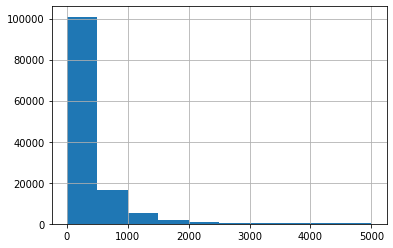

In [12]:
train.comment_text.apply(lambda x : len(x)).hist()

In [13]:
non_negaitve_comments = len(train[train.iloc[:,2:].apply(lambda x: sum(x), axis=1)==0])
negative_comments = len(train)-non_negaitve_comments
print("non_negaitve_comments: ",non_negaitve_comments)
print("negative_comments: ",negative_comments)
print(f"percentage of non negaitve comments :{non_negaitve_comments/len(train)*100}%")

non_negaitve_comments:  114670
negative_comments:  12987
percentage of non negaitve comments :89.82664483733755%


In [14]:
multiple_labels = len(train[train.iloc[:,2:].apply(lambda x: sum(x), axis=1)>1])
print("multiple labeled comments: ",multiple_labels)

multiple labeled comments:  7914


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

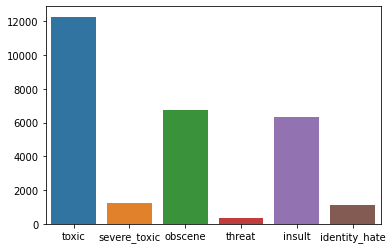

In [12]:
categories = []
values = []
for column in train.columns[2:]:
    categories.append(column)
    values.append(train[column].sum())

sns.barplot(categories,values)

In [44]:
def word_cloud(column):
    corpus = []
    category_df = train[train[column] ==1].reset_index(drop=True)
    for j in tqdm(range(0, len(category_df))):
        comment = re.sub('[^a-zA-Z]', ' ', category_df['comment_text'][j]) 
        comment = comment.lower() 
        comment = comment.split() 
        all_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer() 
        comment = [lemmatizer.lemmatize(word) for word in comment if not word in set(all_stopwords)]
        comment = ' '.join(comment)
        corpus.append(comment)
        
    text = ' '.join(corpus)
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(column,fontsize=40)
    plt.axis("off")


  0%|          | 0/12259 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/6784 [00:00<?, ?it/s]

  0%|          | 0/385 [00:00<?, ?it/s]

  0%|          | 0/6322 [00:00<?, ?it/s]

  0%|          | 0/1135 [00:00<?, ?it/s]

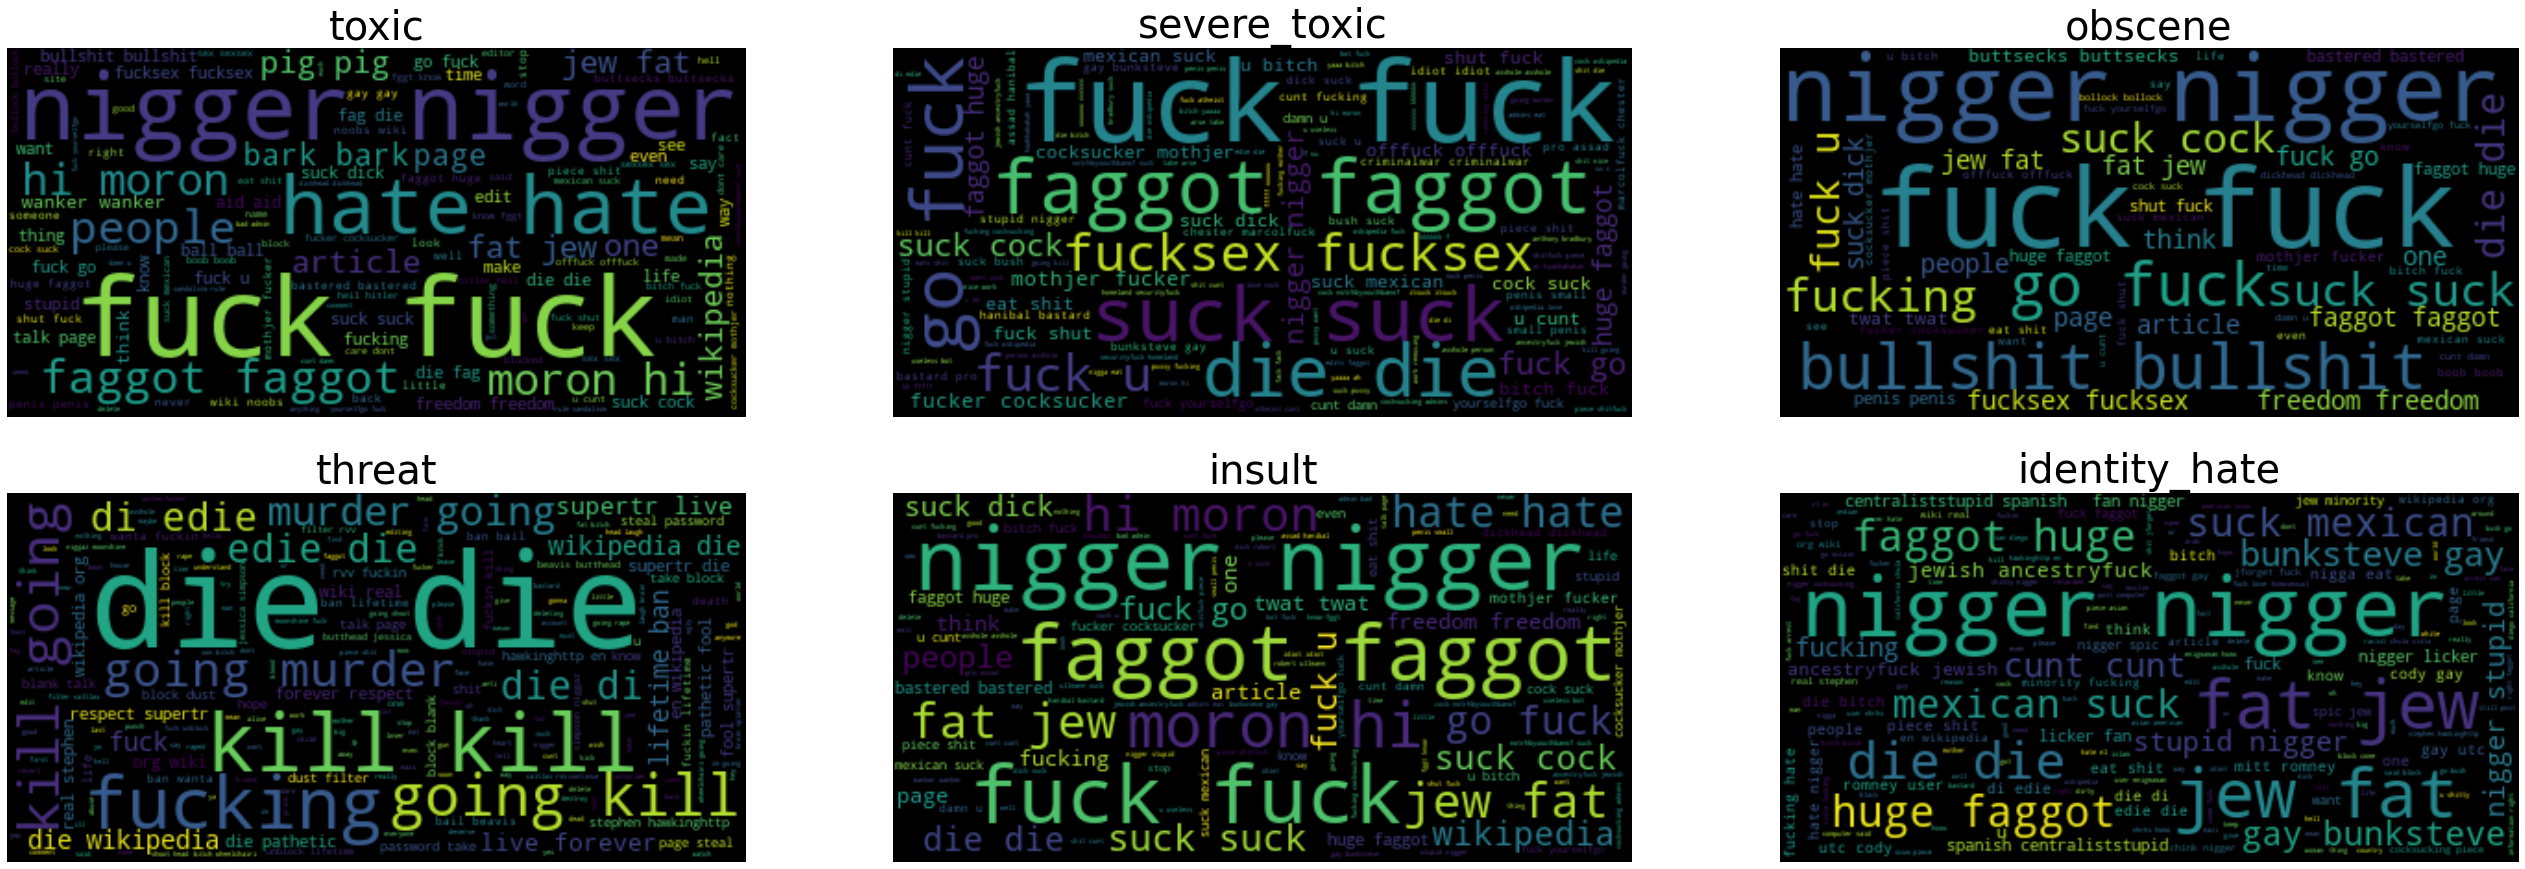

In [45]:
plt.figure(figsize=(45,15))
c = 1
for column in train.columns[2:]:
    plt.subplot(2,3,c)
    word_cloud(column)
    c=c+1

plt.show()

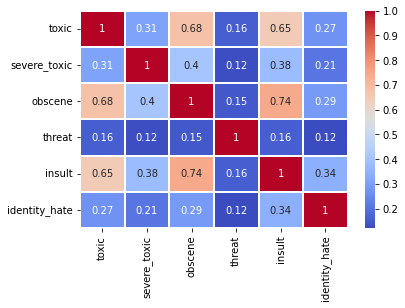

In [20]:
sns.heatmap(train.corr(), annot=True,cmap="coolwarm",linewidths=0.1)
plt.show()

In [26]:
def clean_text(data):
    corpus = []
    for j in tqdm(range(0, len(data))):
        comment = re.sub('[^a-zA-Z]', ' ', data['comment_text'][j]) 
        #comment = comment.replace('\n','')
        comment = comment.lower() 
        comment = comment.split() 
        lemmatizer = WordNetLemmatizer() 
        comment = [lemmatizer.lemmatize(word) for word in comment]
        comment = ' '.join(comment)
        corpus.append(comment)
        
    return corpus

In [27]:
train_corpus = clean_text(train)

  0%|          | 0/127657 [00:00<?, ?it/s]

In [32]:
test_corpus = clean_text(test)

  0%|          | 0/31914 [00:00<?, ?it/s]

In [33]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values

##  Tf-idf

In [39]:
vec = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X_train = vec.fit_transform(train_corpus)
X_test = vec.transform(test_corpus)

In [40]:
X_train.shape,X_test.shape

((127657, 316421), (31914, 316421))

In [42]:
predictions = pd.DataFrame()
predictions['id'] = test['id']

In [43]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for class_name in class_names:
    target_label = train[class_name]
    from sklearn.naive_bayes import MultinomialNB
    classifier = MultinomialNB()
    classifier.fit(X_train, target_label)
    pred = classifier.predict(X_test)
    predictions[class_name] = pred
    print(f"accuracy {class_name}: {accuracy_score(test[class_name], predictions[class_name])}")
    

accuracy toxic: 0.9273986338284138
accuracy severe_toxic: 0.9898477157360406
accuracy obscene: 0.9566021181926427
accuracy threat: 0.9968039105094942
accuracy insult: 0.9569781287209376
accuracy identity_hate: 0.9901923920536442
